<a href="https://colab.research.google.com/github/lucasjirwin/Intrinsically-motivated-Prospect-Theory-RL-agent/blob/main/Thesis_Training_Reward_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required installs

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **GridWorld Class**
*Python class to represent an MDP gridworld environment. Methods include (i) getting available actions in a given state (ii) printing the agent on the map (iii) returning the reward for the current location (iv) making a step in the environment (taking action, $a_t$ in state, $s_t$ and observing reward, $r_t$) and (v) checking if the agent is in a terminal state*  


In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 25
        self.width = 25
        self.grid = np.zeros(( self.height, self.width)) -1
        
        # Set random start location for the agent
        # self.current_location = (np.random.choice([0,7,8,9]),0)
        self.current_location = (0, np.random.randint(0,24))
        
        # Set locations for the bomb and the gold
        self.bomb_locations =[(0,12), (10,12), (11,12),(12,10),(12,11),(12,12),(12,13),(12,14),(13,12),(14,12),(24,12)]
        self.gold_locations = [(np.random.choice([0,24]),np.random.choice([0,24]))]
    
        # self.gold_locations = [((np.random.randint(0, 10), 19))]
        # self.gold_locations = [(np.random.choice([0,9]),19)]
        self.terminal_states = self.gold_locations + self.bomb_locations
        
        # Set grid rewards for special cells
        for bomb_location in self.bomb_locations:
          self.grid[bomb_location[0],bomb_location[1]] = -10

        for gold_location in self.gold_locations:
          self.grid[gold_location[0],gold_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid, self.current_location[0], self.current_location[1]
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

# **Q-learning Agent Class**
*Python class to represent an MDP gridworld environment. Methods include (i) getting available actions in a given state (ii) printing the agent on the map (iii) returning the reward for the current location (iv) making a step in the environment (taking action, $a_t$ in state, $s_t$ and observing reward, $r_t$) and (v) checking if the agent is in a terminal state*  

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0, alpha=0.1, gamma=0.99, aspiration = 0, weight_1 = 1, weight_2 = 1, weight_alpha = 1, weight_beta=1, weight_lambda = 1, use_prospect = False, use_aspiration = False, use_both = False):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        # aspiration model parameters
        self.aspiration = aspiration
        self.weight_1 = weight_1
        self.weight_2 = weight_2
        # prospect model parameters 
        self.weight_alpha = weight_alpha
        self.weight_beta = weight_beta
        self.weight_lambda = weight_lambda
        self.use_aspiration = use_aspiration
        self.use_prospect = use_prospect 
        self.use_both = use_both 
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    # Transforms the reward using aspiration from Dubey et al.
    def get_aspiration(self, reward):
      """Shapes the reward with the aspiration reward function"""
      return (self.weight_1 * reward) + (self.weight_2 * (reward - self.aspiration))
   
   # Transforms the reward using the prospect theory value function
    def get_value_function(self, reward):
      """Shapes the reward with the prospect reward function """
      if (reward >= 0):
        return (reward)**(self.weight_alpha)
      else:
        return -self.weight_lambda * (-reward)**self.weight_beta

    def get_aspiration_prospect(self, reward):
      """Shapes the reward with the combined aspiration-prospect reward function """
      if (reward >= 0):
        return (reward)**(self.weight_alpha) + (self.weight_2 * (reward - self.aspiration))
      else:
        return -self.weight_lambda * (-reward)**self.weight_beta 
        + (self.weight_2 * (reward - self.aspiration))
  

    # Updates the Q-table with the Q-learning algorithm
    def learn(self, old_state, reward, new_state, action):
      """Updates the Q-value table using Q-learning"""
      q_values_of_state = self.q_table[new_state]
      max_q_value_in_new_state = max(q_values_of_state.values())
      current_q_value = self.q_table[old_state][action]
      # Decide which reward function to use
      if self.use_prospect:
        reward = self.get_value_function(reward)
      if self.use_aspiration:
        reward = self.get_aspiration(reward)
      if self.use_both:
        reward = self.get_aspiration_prospect(reward)
      self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)


In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    grid = np.zeros((25, 25)) # Grid for visualization 
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            _, i, j = environment.agent_on_map()
            grid[i][j]+=1
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            # visualizing grid code
        
            
            if environment.check_state() == 'TERMINAL':# If game is in terminal state, game over and start next trial
                _, i, j = environment.agent_on_map()
                grid[i][j]+=1
                environment.__init__()
                game_over = True     

            

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
    
    return reward_per_episode # Return performance log

# **Visualize Visits**
## *Runs an agent and visualizes the number of visits in an environment*

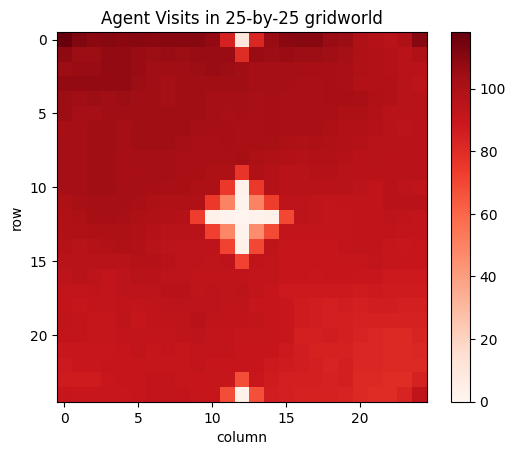

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Simulate the agent's visits over 500 trials and update the grid
environment = GridWorld()
agent = Q_Agent(environment,weight_alpha=0.0, weight_beta=1.9908565185708667, weight_lambda =  1.0,
                           use_prospect=True)
_, grid = play(environment, agent, learn = True, trials=100)

         

# Create a heat map that makes the cells darker as the value increases
cmap = plt.get_cmap('Reds')
normalize = plt.Normalize(vmin=0, vmax=np.max(grid))

# Create a figure and plot the grid as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(grid, cmap=cmap, norm=normalize)

# Add a color bar to show the mapping of values to colors
cbar = plt.colorbar(heatmap)

# Set the tick labels to show the number of visits to each state
# ax.set_xticklabels(range(1, 11))
# ax.set_yticklabels(range(1, 11))

# Set the axis labels and title
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('Agent Visits in 25-by-25 gridworld')

# Show the plot
plt.show()


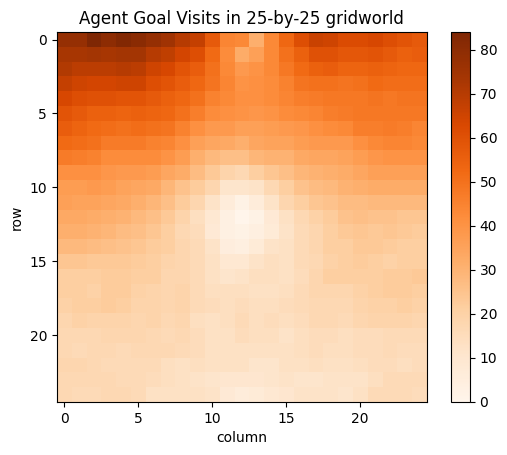

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the grid


# Simulate the agent's visits over 500 trials and update the grid
environment_2 = GridWorld()
agent_2 = Q_Agent(environment_2,  aspiration = 95.5678837426283,
  weight_1 = 0.14334321777509418,
  weight_2 =  0.9790662405514902, use_aspiration=True)
_, grid = play(environment_2, agent_2, learn = True, trials=100)


# Create a color map that makes the cells darker as the value increases
cmap = plt.get_cmap('Oranges')
normalize = plt.Normalize(vmin=0, vmax=np.max(grid))

# Create a figure and plot the grid as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(grid, cmap=cmap, norm=normalize)

# Add a color bar to show the mapping of values to colors
cbar = plt.colorbar(heatmap)

# Set the tick labels to show the number of visits to each state
# ax.set_xticklabels(range(1, 4))
# ax.set_yticklabels(range(1, 12))

# Set the axis labels and title
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('Agent Goal Visits in 25-by-25 gridworld')

# Show the plot
plt.show()


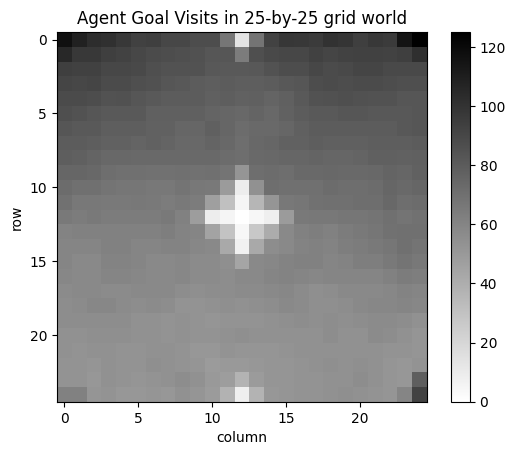

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the grid


# Simulate the agent's visits over 500 trials and update the grid
environment_3 = GridWorld()
agent_3 = Q_Agent(environment_3,epsilon=0.1)
_, grid = play(environment_3, agent_3, learn = True, trials=100)

         
# 
# Create a color map that makes the cells darker as the value increases
cmap = plt.get_cmap('binary')
normalize = plt.Normalize(vmin=0, vmax=np.max(grid))

# Create a figure and plot the grid as a heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(grid, cmap=cmap, norm=normalize)

# Add a color bar to show the mapping of values to colors
cbar = plt.colorbar(heatmap)

# Set the tick labels to show the number of visits to each state
# ax.set_xticklabels(range(1, 4))
# ax.set_yticklabels(range(1, 12))

# Set the axis labels and title
ax.set_xlabel('column')
ax.set_ylabel('row')
ax.set_title('Agent Goal Visits in 25-by-25 grid world')

# Show the plot
plt.show()


# Testing Epsilon, Aspiration and Prospect Models 

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def optimize(epsilon=0, aspiration=1, weight_1=1, weight_2=1, weight_alpha=1, weight_beta=1, weight_lambda=1, use_aspiration=False, use_prospect=False):
    """
    implements function to optimize parameters for a Q-learning agent  
    """
    environment = GridWorld()
    agent = Q_Agent(environment,weight_alpha = weight_alpha, weight_beta = weight_beta,
                    epsilon=epsilon, aspiration=aspiration, weight_lambda = weight_lambda,
                    weight_1=weight_1, weight_2=weight_2,
                    use_prospect=True)
    reward_per_episode = play(environment, agent, learn = True)
    return np.mean(reward_per_episode[200:])

In [ ]:
hyperparameter_bounds = {
    'weight_alpha':(0,1),
    'weight_beta': (0,3),
    'weight_lambda': (1,5)
}


# Initialize the optimizer and begin the search
optimizer = BayesianOptimization(
    f=optimize,
    pbounds=hyperparameter_bounds,
    verbose=2,
    allow_duplicate_points=True
)
optimizer.maximize(n_iter=100, allow_duplicate_points=True)

|   iter    |  target   | weight... | weight... | weight... |
-------------------------------------------------------------


<ipython-input-42-d0d2844246c8>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optimizer.maximize(n_iter=100, allow_duplicate_points=True)


| 1         | -13.84    | 0.09941   | 2.237     | 3.275     |
| 2         | -13.86    | 0.0288    | 1.025     | 1.406     |
| 3         | -13.83    | 0.1273    | 1.91      | 2.194     |
| 4         | -13.81    | 0.7148    | 0.9213    | 2.712     |
| 5         | -13.82    | 0.4076    | 2.023     | 3.82      |
| 6         | -13.81    | 0.7052    | 0.9195    | 2.654     |
| 7         | -13.79    | 0.6969    | 0.8867    | 2.968     |
| 8         | -13.86    | 1.0       | 1.124     | 3.269     |
| 9         | -13.86    | 0.1711    | 2.196     | 1.899     |
| 10        | -13.87    | 0.5163    | 0.7113    | 2.947     |
| 11        | -13.79    | 0.7633    | 0.9618    | 2.906     |
| 12        | -13.89    | 0.8376    | 0.8132    | 2.946     |
| 13        | -13.85    | 0.6736    | 2.73      | 3.188     |
| 14        | -13.78    | 0.6602    | 0.9779    | 2.89      |
| 15        | -13.83    | 0.735     | 1.016     | 2.976     |
| 16        | -13.83    | 0.6466    | 0.9556    | 2.811     |
| 17    

In [ ]:
optimizer.max

{'target': -13.75,
 'params': {'weight_alpha': 0.664267842783181,
  'weight_beta': 2.8666181746362938,
  'weight_lambda': 4.711009235517647}}

In [ ]:
# define a function to run the code for a given number of times
def run_experiment(num_runs, epsilon=0, aspiration=1, weight_1=1, weight_2=1,
                   weight_alpha=0, weight_beta=0, weight_lambda=0,
                   use_aspiration=False, use_prospect=False):
   # define the environment and agent
    environment= GridWorld()
    agent = Q_Agent(environment, epsilon=epsilon, aspiration=aspiration, 
                    weight_1=weight_1, weight_2=weight_2, weight_alpha=weight_alpha, 
                    weight_beta=weight_beta, weight_lambda=weight_lambda, 
                    use_aspiration=use_aspiration, use_prospect=use_prospect)
    rewards = []
    for i in range(num_runs):
        reward_per_episode = play(environment, agent, learn=True, trials=100)
        rewards.append(reward_per_episode)
    return rewards

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

In [ ]:
rewards_1 = run_experiment(50, epsilon = 0.1)
print(rewards_1)
# calculate the average and confidence intervals of the rewards
avg_rewards_1 = np.mean(rewards_1, axis= 0)
ci = sem(rewards_1, axis=0)   # 95% confidence interval* 1.96

rewards_2 = run_experiment(50, aspiration = 7.899130806266369,
  weight_1 = 0.01833138711218263,
  weight_2 = 0.6600803556687961, 
use_aspiration=True)
print(rewards_2)
avg_rewards_2 = np.mean(rewards_2, axis= 0)
ci_2 = sem(rewards_2, axis=0)  # 95% confidence interval


rewards_3 = run_experiment(50, weight_alpha=0.0, 
                           weight_beta=1.9908565185708667, weight_lambda =  1.0,
                           use_prospect=True)

# 'weight_alpha': 0.9645957444920839,
#   'weight_beta': 0.4697866570151882,
#   'weight_lambda': 1.9471427334308289

# calculate the average and confidence intervals of the rewards
print(rewards_3)
avg_rewards_3 = np.mean(rewards_3, axis= 0)
ci_3 = sem(rewards_3, axis=0)  # 95% confidence interval

[[-741.0, -18.0, -185.0, -221.0, -495.0, -60.0, -409.0, -56.0, -392.0, -399.0, -150.0, -312.0, -87.0, -600.0, -429.0, -343.0, 2.0, -182.0, -137.0, -335.0, -327.0, -80.0, -790.0, -383.0, -11.0, -383.0, -552.0, -221.0, -407.0, -518.0, -1000.0, -321.0, -184.0, -779.0, -203.0, -121.0, -27.0, -691.0, -347.0, -97.0, -12.0, -35.0, -385.0, -1000.0, -803.0, -1000.0, -1000.0, -1000.0, -455.0, 8.0, -1000.0, -58.0, -30.0, -583.0, -306.0, -312.0, -573.0, -591.0, -1000.0, -508.0, -657.0, -1000.0, -897.0, -1000.0, -206.0, -350.0, -490.0, -754.0, -205.0, -1000.0, -544.0, -457.0, -159.0, -347.0, -46.0, -498.0, -1000.0, -165.0, -137.0, -10.0, -802.0, -563.0, -214.0, -115.0, -293.0, -556.0, -1000.0, -162.0, -1000.0, -17.0, -306.0, -118.0, -696.0, -10.0, -173.0, -15.0, -452.0, -170.0, -1000.0, -809.0], [-155.0, -813.0, -799.0, -635.0, -680.0, -1000.0, -382.0, -737.0, -561.0, -867.0, -796.0, -1000.0, -95.0, -647.0, -249.0, -239.0, 10.0, -1000.0, -11.0, -10.0, -183.0, -574.0, -676.0, -129.0, -4.0, -585.0, -

[[-22.0, -645.0, -158.0, -757.0, -267.0, -10.0, -63.0, -477.0, -1000.0, -231.0, -309.0, -31.0, -270.0, -235.0, -58.0, -385.0, -752.0, -65.0, -465.0, -286.0, -7.0, -594.0, -58.0, -103.0, -72.0, -736.0, 10.0, -542.0, 10.0, -42.0, -390.0, -333.0, -195.0, -754.0, -134.0, 9.0, -871.0, -140.0, -257.0, -1000.0, -1000.0, -303.0, -967.0, -1000.0, -66.0, -926.0, -1000.0, -5.0, -162.0, -256.0, -1000.0, -528.0, -778.0, -95.0, -398.0, -1000.0, -409.0, -381.0, -213.0, -950.0, -100.0, -105.0, -1000.0, -1000.0, -890.0, -1000.0, -697.0, -476.0, -152.0, -967.0, -351.0, -1000.0, -375.0, -128.0, -216.0, -867.0, -263.0, -613.0, -364.0, -161.0, -17.0, -335.0, -48.0, -51.0, 9.0, -465.0, -517.0, -288.0, -1000.0, -17.0, 5.0, -599.0, -300.0, -10.0, -287.0, -1000.0, -472.0, -855.0, -397.0, -684.0, 9.0, -57.0, -445.0, -1000.0, -100.0, -440.0, -1000.0, -309.0, -754.0, -452.0, -247.0, -297.0, -783.0, -1000.0, -1000.0, -184.0, -1000.0, -69.0, -263.0, -420.0, -1000.0, -618.0, -1000.0, 5.0, -389.0, -10.0, 9.0, -651.0,

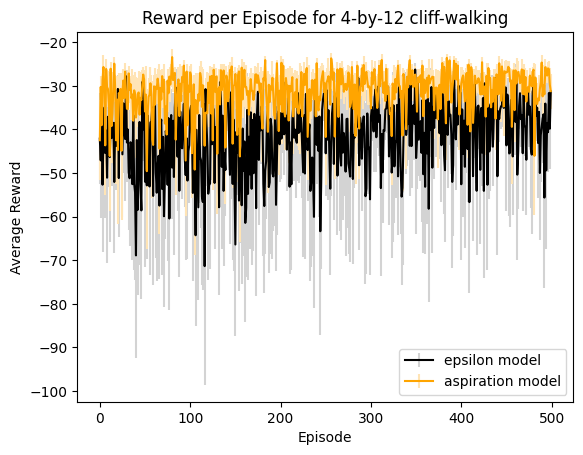

In [ ]:
# # run the experiment 50 times and collect the rewards
num_experiments = 50
rewards_1 = run_experiment(50, epsilon = 0.1)
print(rewards_1)
# calculate the average and confidence intervals of the rewards
avg_rewards_1 = np.mean(rewards_1, axis= 0)
ci = sem(rewards_1, axis=0)   # 95% confidence interval* 1.96


# Calculate the moving average

# plot the results
plt.errorbar(np.arange(len(avg_rewards_1)), avg_rewards_1, yerr = ci, color='black',
             ecolor='lightgray', label="epsilon model" )

rewards_2 = run_experiment(50, aspiration = 7.899130806266369,
  weight_1 = 0.01833138711218263,
  weight_2 = 0.6600803556687961, 
use_aspiration=True)

# calculate the average and confidence intervals of the rewards
print(rewards_2)
avg_rewards_2 = np.mean(rewards_2, axis= 0)
ci_2 = sem(rewards_2, axis=0)  # 95% confidence interval
# Calculate the moving average

#plot the results
plt.errorbar(np.arange(len(avg_rewards_2)), avg_rewards_2, yerr = ci_2, color='orange',
             ecolor='moccasin',label ="aspiration model" )

num_experiments = 50


# rewards_3 = run_experiment(50, weight_alpha=0.0, 
#                            weight_beta=1.9908565185708667, weight_lambda =  1.0,
#                            use_prospect=True)

# # 'weight_alpha': 0.9645957444920839,
# #   'weight_beta': 0.4697866570151882,
# #   'weight_lambda': 1.9471427334308289

# # calculate the average and confidence intervals of the rewards
# print(rewards_3)
# avg_rewards_3 = np.mean(rewards_3, axis= 0)
# ci_3 = sem(rewards_3, axis=0)  # 95% confidence interval

# #plot the results
# plt.errorbar(np.arange(len(avg_rewards_3)), avg_rewards_3, yerr = ci_3, color='darkred',
#              ecolor='lightsalmon',label ="prospect model" )

plt.title("Reward per Episode for 4-by-12 cliff-walking")
plt.xlabel("Episode")
plt.ylabel("Average Reward") 
plt.legend(loc ='lower right')
plt.show()

In [ ]:
np.mean(ci)

9.894883467143176

In [ ]:
np.mean(ci_2)

4.257793687675778

1
1


<ErrorbarContainer object of 3 artists>

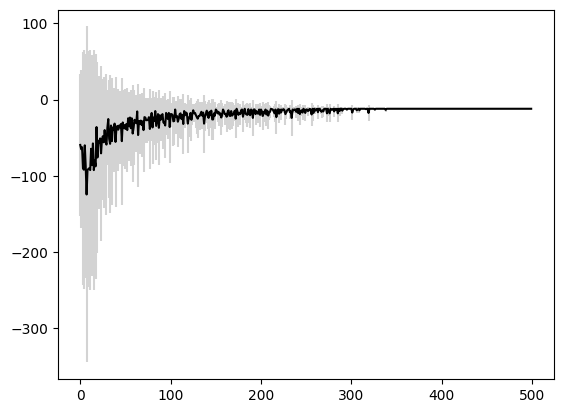

In [ ]:
environment= GridWorld()
agent = Q_Agent(environment, weight_alpha=0.4723860154348559, 
                    weight_beta=2.9070216679235967, 
                    weight_lambda=1.6779081752467233, use_prospect=True)
rewards = []
for i in range(2):
    reward_per_episode = play(environment, agent, learn=True, trials=500)
    print(1)
    rewards.append(reward_per_episode)

avg_rewards = np.mean(rewards, axis= 0)
ci = sem(rewards, axis=0) * 1.96  # 95% confidence interval

# plot the results
plt.errorbar(np.arange(len(avg_rewards)), avg_rewards, yerr = ci, color='black',
             ecolor='lightgray', label="prospect model" )

In [ ]:
np.mean(ci)

5.717703773835044

In [ ]:
np.mean(ci_2)

0.76724

In [ ]:
np.mean(ci_3)

0.28784000000000004

In [ ]:
avg_rewards_1

array([-50.636, -38.442, -33.71 , -37.668, -34.234, -33.97 , -36.462,
       -36.326, -37.258, -35.502, -37.41 , -36.54 , -37.042, -37.548,
       -38.754, -33.984, -37.078, -40.6  , -39.136, -37.246, -38.474,
       -36.794, -37.654, -33.416, -37.86 , -36.648, -36.278, -33.844,
       -35.176, -37.012, -37.626, -40.7  , -37.882, -36.702, -37.832,
       -37.712, -35.294, -37.462, -40.348, -37.242, -34.668, -38.088,
       -37.56 , -35.356, -38.528, -37.478, -39.62 , -36.614, -37.46 ,
       -36.664])

In [ ]:
print(np.sum(avg_rewards_1)/500)
print(np.sum(avg_rewards_1[:200])/200)
print(np.sum(avg_rewards_1[:100])/100)
print(np.sum(avg_rewards_1[-300:])/300)
print(np.sum(avg_rewards_1[-100:])/100)

-38.2042
-40.3995
-42.647
-36.74066666666667
-36.65


In [ ]:
print(np.sum(avg_rewards_2)/500)
print(np.sum(avg_rewards_2[:200])/200)
print(np.sum(avg_rewards_2[:100])/100)
print(np.sum(avg_rewards_2[-100:])/100)

-15.835
-19.019000000000002
-21.641
-12.573999999999998


In [ ]:
print(np.sum(avg_rewards_3)/500)
print(np.sum(avg_rewards_3[:200])/200)
print(np.sum(avg_rewards_3[:100])/100)
print(np.sum(avg_rewards_3[-200:])/200)
print(np.sum(avg_rewards_3[-100:])/100)

-13.4402
-15.438000000000002
-17.681
-12.009500000000001
-12.0


In [ ]:
np.sum(avg_rewards_1)/1000

-11.66014

In [ ]:
np.sum(avg_rewards_1[:100])/100

-5.928199999999999

In [ ]:
np.sum(avg_rewards_1[:200])/200

-5.716899999999999

In [ ]:
np.sum(avg_rewards_1[-100:])/100

-4.9616

In [ ]:
np.sum(avg_rewards_3)/1000

-2.70288

In [ ]:
np.sum(avg_rewards_3[:100])/100

-3.1402000000000005

In [ ]:
np.sum(avg_rewards_3[:200])/200

-3.0387

In [ ]:
np.sum(avg_rewards_3[-100:])/100

-2.4539999999999993

[[-29.0, -76.0, -188.0, -108.0, -11.0, -83.0, 8.0, -132.0, -73.0, -68.0, -45.0, 6.0, -39.0, -21.0, -34.0, -41.0, -73.0, -11.0, -61.0, -17.0, -11.0, -26.0, 7.0, 4.0, -225.0, -31.0, -20.0, -14.0, -17.0, -33.0, 9.0, -27.0, -16.0, -134.0, -73.0, -11.0, -34.0, -138.0, -17.0, -19.0, -52.0, -52.0, -11.0, -26.0, -28.0, -10.0, -57.0, -69.0, -49.0, -38.0, -14.0, 10.0, -88.0, -64.0, -10.0, -10.0, -71.0, -11.0, -116.0, -30.0, -22.0, -16.0, -31.0, -25.0, -86.0, -36.0, -21.0, -53.0, -92.0, -40.0, -10.0, -66.0, -80.0, -40.0, -21.0, -16.0, -33.0, -31.0, -28.0, -19.0, -10.0, -77.0, -16.0, -11.0, -43.0, -2.0, -96.0, -38.0, 4.0, -10.0, -63.0, -75.0, -18.0, -27.0, -77.0, -45.0, -13.0, -20.0, -16.0, -10.0, -11.0, -36.0, -11.0, -36.0, -30.0, -13.0, -49.0, -10.0, -59.0, -42.0, 9.0, -13.0, -138.0, -75.0, -67.0, -12.0, -33.0, -13.0, -38.0, -12.0, -38.0, -31.0, -11.0, -11.0, -111.0, -24.0, -17.0, -19.0, -138.0, -4.0, -16.0, -114.0, -27.0, -11.0, -13.0, -25.0, -15.0, -12.0, -35.0, -67.0, -79.0, -55.0, -14.0, -25

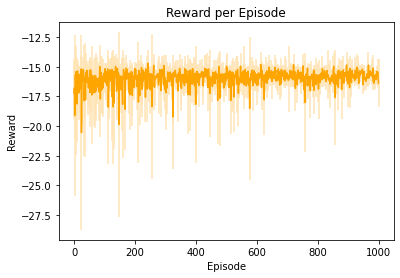

In [ ]:
# run the experiment 50 times and collect the rewards
num_experiments = 50
rewards_2 = run_experiment(50, aspiration = 86.22432654685159, weight_1 = 0.0, weight_2 = 1.0)
# calculate the average and confidence intervals of the rewards
print(rewards_2)
avg_rewards_2 = np.mean(rewards_2, axis= 0)
ci = sem(rewards_2, axis=0) * 1.96  # 95% confidence interval

# plot the results
plt.errorbar(np.arange(len(avg_rewards_2)), avg_rewards_2, yerr = ci, color='orange',
             ecolor='moccasin' )


plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward") 
plt.show()

<ErrorbarContainer object of 3 artists>

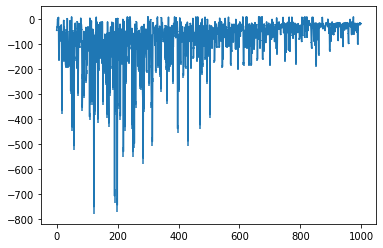

In [ ]:
plt.errorbar(np.arange(len(avg_rewards)), rewards[0], yerr=ci)

In [ ]:
print(np.mean(reward_per_episode[:100]))
print(np.mean(reward_per_episode_3[:100]))
# print(np.mean(reward_per_episode3))

# add error bars for average 
# run 50 agents, store the runs, average and plot and get error bars 

-43.43
-40.4


In [ ]:
# bomb locations: [(0,3),(3,2),(3,3),(3,4),(2,3),(4,3)]
# gold location randomly (0,0), (0,6), (6,0), (6,6)
# p = 75.88569095297652
# -13.844 p = 0 (first 200 episodes)
# -13.0808 p =75.88569095297652 (first 200 episodes)

In [ ]:
# 7x7
# bomb locations: [(0,3),(3,2),(3,3),(3,4),(2,3),(4,3)]
# gold location randomly (0,0), (0,6), (6,0), (6,6)
# 
# Aspiration Model 
# aspiration': 80.53016952011517,
  # 'weight_1': 0.5261784490186152,
  # 'weight_2': 0.9168852358752286
#
#
# Prospect Model
# 'weight_alpha': 0.7943168993202018,
#   'weight_beta': 0.1,
#   'weight_lambda': 2.0918905490591886
# #

In [ ]:
 # 13x13 grid
 # bomb_locations: [(0,6),(4,6), (5,6),(6,4),(6,5),(6,6),(6,7),(6,8),(7,6),(8,6),(12,6)]
 # gold location randomly (0,0), (0,12), (12,0), (12,12)
 # aspiration = 86.22432654685159, weight_1 = 0.0, weight_2 = 1.0
 # -19.3334 p = 0
 # -16.3978 p = 86.22432654685159


 # Prospect Theory
 #weight_p= 0.0014073087193225975, factor_p = 2.222445733200897

In [ ]:
# 25x25 grid 
# self.bomb_locations = [(0,12), (10,12), (11,12),(12,10),(12,11),(12,12),(12,13),(12,14),(13,12),(14,12),(24,12)]
# self.gold_locations = [(0,0),(0,24),(24,0),(24,24)]
#'aspiration': 95.5678837426283,
#   'weight_1': 0.14334321777509418,
#   'weight_2': 0.9790662405514902}

# Prospect Theory 
# 'weight_alpha': 0.0,
  # 'weight_beta': 0.0,
  # 'weight_lambda': 4.670376634907947


  # 'weight_alpha': 1.0,
  # 'weight_beta': 0.1,
  # 'weight_lambda': 4.734107902509065

In [ ]:
# Cliff Walking environment 1
# 4-by-12 (Sutton and Barto)
# 
#
#

# Epsilon 
# e = 0
#
# -12.335399999999998
# -12.7836
# -13.255600000000001
# -12.0

# Prospect
#  weight_alpha=0.0, 
#  weight_beta=5.058256485892731, 
#  weight_lambda = 1.0,
# -12.28856
# -12.691399999999998
# -13.1472
# -12.0

# Aspiration
# aspiration = 0.6872326715537247,
#   weight_1 = 0.24334042634957842,
#   weight_2 = 0.6373570338178125, 
#
# -12.36616
# -12.8534
# -13.327600000000002
# -12.0


# Cliff Walking environment 2
# 4-by-12 
# self.bomb_locations = [(3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3,10),
#                        (2,1), (2,2), (2,3), (2,4), (2,5), (2,6), (2,7), (2,8), (2,9), (2,10)]
# self.gold_locations = [(3, np.random.choice([0,1,2,3]))]
# bomb_r = -100
# gold_r = 10 
# step = -1 
# Epsilon Model
# epsilon: 0.07272418282573467
#
# Aspiration Model 
# aspiration = 7.899130806266369,
#   weight_1 = 0.01833138711218263,
#   weight_2 = 0.6600803556687961
# 
#
# Prospect Model 
# weight_alpha=0.0, 
# weight_beta=1.9908565185708667,
# weight_lambda =  1.0,


# Cliff Walking environment 3 
# 
# Epsilon Model 
# epsilon 0.7659912639497275
#
# Aspiration Model
# aspiration = 68.02926524408814,
#   weight_1 = 0.9748524724848019,
#   weight_2 = 0.939841882241377
#
# Prospect Model
# weight_alpha = 0.05847543935000277,
# weight_beta = 0.00954667939907139,
# weight_lambda = 0.65754748281457

In [ ]:
# Bayesian optimizer
# 100 iterations
# 

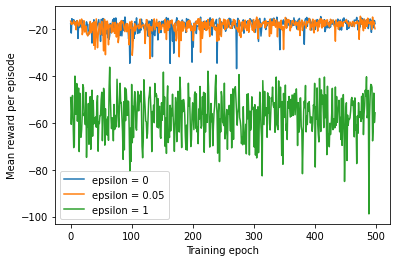

In [ ]:
environment_1 = GridWorld()
agent_1 = Q_Agent(environment_1, epsilon = 0)

reward_per_episode_1 = play(environment_1, agent_1, learn = True)
for i in range(49):
 reward_per_episode_1 = [sum(x) for x in zip(reward_per_episode_1,play(environment_1, agent_1, learn = True))]

reward_per_episode_1 = [x/50 for x in reward_per_episode_1] 
plt.plot(reward_per_episode_1, label = "epsilon = 0")

environment_2 = GridWorld()
agent_2 = Q_Agent(environment_2, epsilon = 0.05)

reward_per_episode =play(environment_2, agent_2, learn = True)
for i in range(49):
 reward_per_episode = [sum(x) for x in zip(reward_per_episode,play(environment_2, agent_2, learn = True))]

reward_per_episode = [x/50 for x in reward_per_episode] 
plt.plot(reward_per_episode, label = "epsilon = 0.05")


environment_3 = GridWorld()
agent_3 = Q_Agent(environment_3, epsilon = 1)

reward_per_episode_3 = play(environment_3, agent_3, learn = True)
for i in range(49):
 reward_per_episode_3 = [sum(x) for x in zip(reward_per_episode_3, play(environment_3, agent_3, learn = True))]

reward_per_episode_3 = [x/50 for x in reward_per_episode_3] 
plt.plot(reward_per_episode_3, label ="epsilon = 1")

plt.xlabel("Training epoch")
plt.ylabel("Mean reward per episode")
plt.legend()
plt.show()

In [ ]:
print(np.mean(reward_per_episode_1[:100]))
print(np.mean(reward_per_episode[:100]))
print(np.mean(reward_per_episode_3[:100]))


-19.234199999999998
-19.6234
-57.075


# Running t-test on means

In [ ]:
# 25-by-25
# 'aspiration': 95.5678837426283,
#   'weight_1': 0.14334321777509418,
#   'weight_2': 0.9790662405514902}

# Prospect Theory 


  # 'weight_alpha': 1.0,
  # 'weight_beta': 0.1,
  # 'weight_lambda': 4.734107902509065


# 7-by-7
  # aspiration': 80.53016952011517,
  # 'weight_1': 0.5261784490186152,
  # 'weight_2': 0.9168852358752286
#
#
# Prospect Model
# 'weight_alpha': 0.7943168993202018,
#   'weight_beta': 0.1,
#   'weight_lambda': 2.0918905490591886
# #

In [ ]:
def calculate_means(runs=20, epsilon=0, aspiration=1, weight_1=1, weight_2=1, weight_alpha=1, weight_beta=1, weight_lambda=1, use_aspiration=False, use_prospect=False):
    """
    implements function to optimize parameters for a Q-learning agent  
    """
    mean_rewards = np.zeros((runs))
    for i in range(runs):
      environment = GridWorld()
      agent = Q_Agent(environment,weight_alpha = weight_alpha, weight_beta = weight_beta,
                    epsilon=epsilon, aspiration=aspiration, weight_lambda = weight_lambda,
                    weight_1=weight_1, weight_2=weight_2,
                    use_aspiration=use_aspiration, use_prospect=use_prospect)
      reward_per_episode = play(environment, agent, learn = True, trials=500)
      mean_rewards[i] = np.mean(reward_per_episode)
      print("helloooooo")
    return mean_rewards

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Generate two sets of mean rewards from the experiment
mean_rewards1 = calculate_means(epsilon=0.1)
mean_rewards2 = calculate_means(aspiration = 95.5678837426283,
  weight_1 = 0.14334321777509418,
  weight_2 = 0.9790662405514902,
                                use_aspiration=True)
mean_rewards3 = calculate_means(weight_alpha=1.0, 
                           weight_beta=0.1, weight_lambda =  4.734107902509065, use_prospect=True)


# Run t-test
t_statistic_asp, p_value_asp = ttest_ind(mean_rewards1, mean_rewards2, equal_var=False)
t_statistic_pro, p_value_pro = ttest_ind(mean_rewards1, mean_rewards3, equal_var=False)

# Print results
print("t-statistic aspiration:", t_statistic_asp)
print("p-value aspiration:", p_value_asp)
print("t-statistic prospect:", t_statistic_pro)
print("p-value prospect:", p_value_pro)

helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
helloooooo
t-statistic aspiration: -204.07830948251546
p-value aspiration: 4.494482674932549e-44
t-statistic prospect: -199.9999181710903
p-value prospect: 3.9824700204910575e-44


In [ ]:
mean_rewards1

array([-243.98 , -237.22 , -205.96 , -237.31 , -272.85 , -207.76 ,
       -235.92 , -238.04 , -233.025, -228.33 , -227.13 , -228.88 ,
       -242.595, -243.98 , -255.6  , -221.565, -242.95 , -265.75 ,
       -229.23 , -227.655, -213.695, -228.76 , -239.49 , -224.24 ,
       -231.6  , -223.83 , -236.725, -228.38 , -237.95 , -227.4  ,
       -219.505, -238.865, -219.74 , -231.165, -203.92 , -223.275,
       -243.39 , -224.67 , -243.34 , -249.155, -216.62 , -232.02 ,
       -233.89 , -235.175, -231.525, -249.82 , -226.09 , -244.225,
       -233.03 , -229.405, -229.875, -238.47 , -199.29 , -240.72 ,
       -209.95 , -252.52 , -223.105, -226.29 , -219.585, -242.495,
       -225.73 , -234.925, -243.09 , -228.8  , -228.405, -221.875,
       -227.335, -255.76 , -235.305, -211.475, -222.62 , -235.135,
       -249.775, -241.015, -241.19 , -230.905, -223.35 , -223.815,
       -252.515, -241.825, -231.84 , -269.455, -246.095, -230.045,
       -234.59 , -225.38 , -260.435, -228.39 , -213.335, -223.

In [ ]:
mean_rewards2

array([-135.39 , -133.755, -129.125, -134.11 , -127.495, -129.335,
       -131.65 , -132.94 , -136.575, -129.51 , -124.66 , -129.8  ,
       -132.805, -130.615, -127.72 , -126.755, -127.41 , -127.14 ,
       -130.915, -129.225, -137.05 , -131.85 , -127.03 , -127.8  ,
       -129.73 , -131.635, -128.585, -129.55 , -129.095, -137.535,
       -129.545, -133.6  , -131.485, -133.55 , -133.635, -134.065,
       -130.525, -131.74 , -132.71 , -131.685, -127.98 , -130.7  ,
       -129.445, -130.83 , -129.015, -132.05 , -127.67 , -134.58 ,
       -131.7  , -133.145, -131.055, -128.335, -125.535, -127.695,
       -131.58 , -129.265, -133.32 , -130.18 , -121.735, -122.215,
       -128.125, -129.265, -133.945, -127.645, -128.365, -127.4  ,
       -130.225, -137.385, -121.51 , -130.15 , -129.45 , -125.14 ,
       -133.74 , -128.7  , -128.135, -134.47 , -130.15 , -132.125,
       -128.555, -127.665, -125.825, -130.975, -129.295, -133.36 ,
       -130.22 , -133.685, -130.455, -136.08 , -130.955, -134.

array([-115.435, -117.2  , -118.92 , -116.415, -117.73 , -119.695,
       -119.425, -115.96 , -118.14 , -121.325, -117.675, -120.085,
       -118.645, -116.015, -118.01 , -118.17 , -118.995, -116.03 ,
       -120.41 , -119.925, -117.725, -122.63 , -120.185, -116.17 ,
       -118.405, -122.285, -118.795, -116.315, -117.53 , -118.21 ,
       -119.565, -121.295, -119.935, -120.615, -119.49 , -117.345,
       -116.515, -119.09 , -120.65 , -119.965, -119.34 , -116.935,
       -115.595, -118.235, -118.145, -122.51 , -121.605, -118.725,
       -117.25 , -118.88 ])